# Vectorized: A fast QAOA simulator for prototyping

This notebook introduces and provides some simple benchmarks (against `qiskit.AerSimulator('statevector')`) to demonstrate the ability to simulate relatively modest QAOA circuits fast.

## Begin by importing necessary modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems.problem import MaximumCut, NumberPartition

#import the QAOA workflow model
from openqaoa.workflows.optimizer import QAOA

#import method to specify the device
from openqaoa.devices import create_device

#importing the time module to record time for simulations
from time import time

## Step 1: Create a problem instance
We begin by creating a problem instance for a simple MaximumCut problem for a random graph created using the python `networkx` module. MaximumCut is a go-to problem to demonstrate QAOA in action.

For this, we first:
- create a random graph using the `networkx` module
- using the MaximumCut problem class, we translate into the QUBO formalism to optimize with QAOA

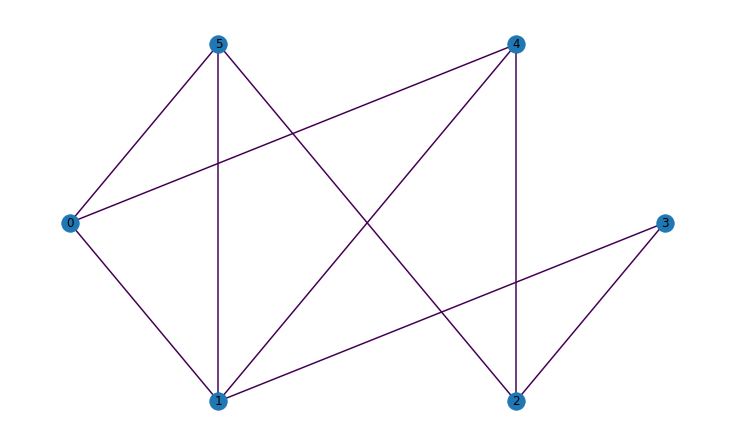

In [3]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes,p=edge_probability)

# import graph plotter from openqaoa
from openqaoa.utilities import plot_graph
plot_graph(g)

In [4]:
# Use the MaximumCut class to instantiate the problem.
maxcut_prob = MaximumCut(g)

# The method `get_qubo_problem()` translates the problem into a binary Qubo problem. 
# The binary values can be access via the `asdict()` method.
maxcut_qubo = maxcut_prob.get_qubo_problem()

In [5]:
pprint(maxcut_qubo.asdict())

{'constant': 0,
 'n': 6,
 'terms': [[0, 1],
           [0, 4],
           [0, 5],
           [1, 3],
           [1, 4],
           [1, 5],
           [2, 3],
           [2, 4],
           [2, 5]],
 'weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


#### Extract the exact solution for a small enough problem



In [6]:
hamiltonian = maxcut_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -7.0, Solution: ['111000', '000111']


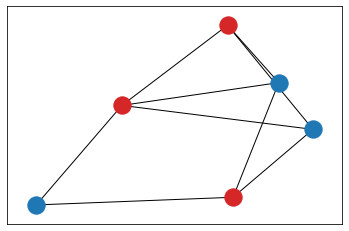

In [7]:
#plot the solution on graph
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos);

## Step 2: Build the QAOA model
We will build two different models with the same exact configurations except the device used. To compare the performance of `vectorized` backend to that of `qiskit.statevector_simulator`.

In [8]:
# initialize model with default configurations
q_vector = QAOA()
q_qiskit = QAOA()

In [9]:
# optionally configure the following properties of the model

# device
qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
q_qiskit.set_device(qiskit_device)

# circuit properties
q_qiskit.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q_qiskit.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q_qiskit.set_classical_optimizer(method='nelder-mead', maxiter=200, optimization_progress=True,
                                 cost_progress=True, parameter_log=True)

In [10]:
# optionally configure the following properties of the model

# device
vectorized_device = create_device(location='local', name='vectorized')
q_vector.set_device(vectorized_device)

# circuit properties
q_vector.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q_vector.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q_vector.set_classical_optimizer(method='nelder-mead', maxiter=200,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

## Step 3: Compile and Optimize

- Once the QAOA model is configured, we need to compile it. **Compilation is necessary** because the QAOA solver has to interact with the problem in to be able to create the underlying QAOA circuit.
- The problem is ready to be optimized now. The user can call `model.optimize()` to initiate the optimization loop. 

Since the purpose of this notebook is to compare the speed performance of vectorized, we will run the optimization loop and record the time required to finish the optimization. Repeating this step for different depth of circuits is also presented.

In [18]:
ps = range(1,10)
times_qiskit = []
times_vectorized = []

for i,p in enumerate(ps):
    
    q_qiskit.set_circuit_properties(p=p, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
    q_qiskit.compile(maxcut_qubo,verbose=False) 
    
    q_vector.set_circuit_properties(p=p, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
    q_vector.compile(maxcut_qubo,verbose=False) 
    
    t1=time()
    q_qiskit.optimize()
    
    t2=time()

    q_vector.optimize()
    t3=time()
    
    times_qiskit.append(t2-t1)
    times_vectorized.append(t3-t2)

optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.
optimization completed.


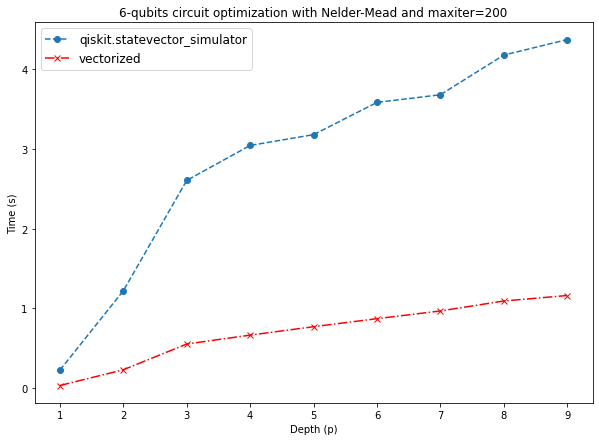

In [26]:
figure = plt.figure(figsize=(10,7))
plt.plot(ps, times_qiskit, ls = '--', marker = 'o', label='qiskit.statevector_simulator')
plt.plot(ps, times_vectorized, color='red', ls='-.', marker='x', label = 'vectorized')
plt.xlabel('Depth (p)')
plt.ylabel('Time (s)')
plt.title('6-qubits circuit optimization with Nelder-Mead and maxiter=200')
plt.legend(fontsize=12);

## Step 4: Accessing the results

Compare the evolution of cost value for both devices for a sanity check

In [23]:
vector_opt_results = q_vector.results
qiskit_opt_results = q_qiskit.results

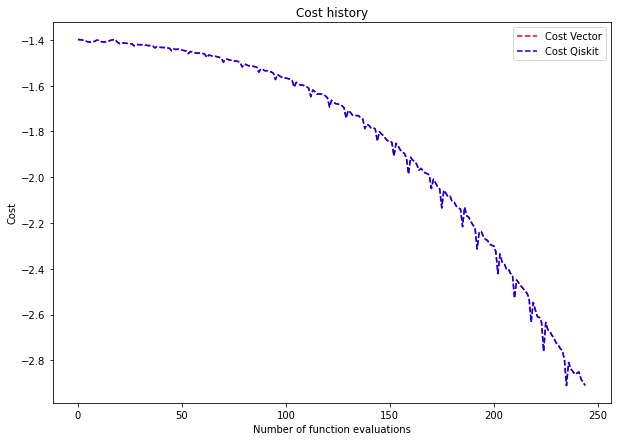

In [24]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
vector_opt_results.plot_cost(label='Cost Vector',color='red',ax=ax)
qiskit_opt_results.plot_cost(label='Cost Qiskit',color='blue',ax=ax)

The two cost histories show a complete match between the two devices